In [1]:
import numpy as np         
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# download mandatory data for nltk package
# nltk.download()

# Data Reading

In [3]:
import pandas as pd

data = pd.read_csv('data/train.csv')
print(f'The number of datapoints is {data.shape}')
data.head(5)

The number of datapoints is (404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
data.info()     # display the data structure

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


# Drop Null Data

In [5]:
data[data.isnull().any(axis=1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [6]:
data = data.dropna()            # drop all rows with null values
data.shape

(404287, 6)

# Exploratory Data Analysis

## Distribution of target variable

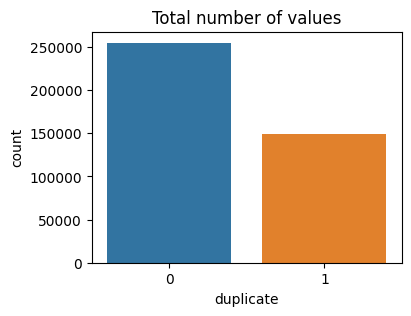

Total number of question pairs is 404287
Question pairs that are similar is 149263 which is 37 % of total
Question pairs that are not similar is 255024 which is 63 % of total


In [7]:
# plotting the number of duplicate pairs and different pairs

plt.figure(figsize=(4,3))
ct = data['is_duplicate'].value_counts()            # create a dictionary to count different values of 'is_duplicate' column
sns.barplot(x=ct.index,y=ct.values)
plt.title('Total number of values')
plt.xlabel('duplicate')
plt.ylabel('count')
plt.show()

print('Total number of question pairs is {}'.format(len(data.id.values)))
print('Question pairs that are similar is {} which is {} % of total'.format(ct[1],round((ct[1]/(ct[1]+ct[0])*100)),2))
print('Question pairs that are not similar is {} which is {} % of total'.format(ct[0],round((ct[0]/(ct[1]+ct[0])*100)),2))

In [8]:
ct

0    255024
1    149263
Name: is_duplicate, dtype: int64

## Number of uniques questions and repeated questions

In [9]:
qids = pd.Series(data.qid2.tolist() + data.qid1.tolist())
uniq = len(np.unique(qids))
print('Total number of unique questions is {}'.format(uniq))
#Number of questions that repeated than 1 time
cnt = qids.value_counts()  # count the number of times each question occured 
more1 = len(cnt[cnt.values > 1])
print('Number of questions that repeated more than 1 time is {} which is {}%'.format(more1,(more1/(len(cnt))*100)))
print('The maximum number of times a question occured is {}'.format(max(cnt)))

Total number of unique questions is 537929
Number of questions that repeated more than 1 time is 111778 which is 20.779322178205675%
The maximum number of times a question occured is 157


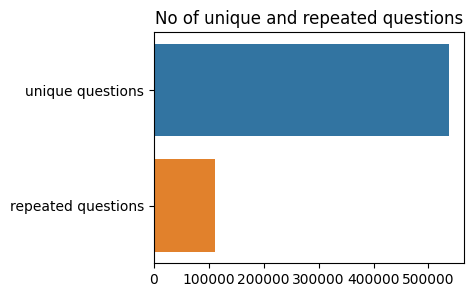

In [10]:
plt.figure(figsize=(4,3))
qts = pd.Series(data=['unique questions','repeated questions'], index=[uniq, more1])
sns.barplot(x=qts.index, y=qts.values)
plt.title('No of unique and repeated questions')
plt.show()

In [11]:
# show top 5 popular questions
for qt in cnt[:5].index:
    if len(data[(data['qid1'] == qt)]['question1'].unique()):
        print(data[(data['qid1'] == qt)]['question1'].unique()[0])
    else:
        print(data[(data['qid2'] == qt)]['question2'].unique()[0])

What are the best ways to lose weight?
How can you look at someone's private Instagram account without following them?
How can I lose weight quickly?
What's the easiest way to make money online?
Can you see who views your Instagram?


# Feature Engineering

We reconstruct the data and add some new features:
 - ____freq_qid1____ = Frequency of qid1's      #ie, number of times question1 occur
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)     
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [12]:
if os.path.isfile('data_with_out_preprocess.csv'):
    data = pd.read_csv("data_with_out_preprocess.csv",encoding='latin-1')
else:
    def common_wrd(row):
        x = set(row['question1'].lower().strip().split(" ")) 
        y = set(row['question2'].lower().strip().split(" "))
        return 1.0 * len(x & y)


    def total(row):
        set1 = set(row['question1'].lower().strip().split(" "))
        set2 = set(row['question2'].lower().strip().split(" "))
        return 1.0 * (len(set1) + len(set2))

    def word_share(row):
        x = row['word_common']/row['word_total']
        return  x

############################################
data['word_common'] = data.apply(common_wrd,axis=1)
data['word_total'] = data.apply(total,axis=1)
data['word_share'] = data.apply(word_share,axis=1)
# data.to_csv("data/data_with_out_preprocess.csv", index=False)

In [13]:
data = pd.read_csv('data/data_with_out_preprocess.csv')
data.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,2,51,88,8,13,4.0,20.0,0.200000,6,2
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0


### Analysing word share

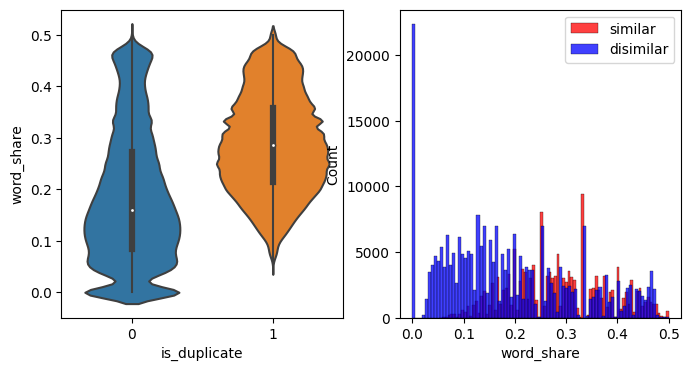

In [14]:
# plotting the relation between dulicate and word_share

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_share',data=data)
plt.subplot(1,2,2)
sns.histplot(data[data['is_duplicate'] == 1]['word_share'],color='red',label='similar')
sns.histplot(data[data['is_duplicate'] == 0]['word_share'],color='blue',label='disimilar')
plt.legend()
plt.show()

We can see that as the word share increases there is a higher chance the questions are similar. From the histogram we can see that word share has some information differentiating similar and dissimilar classes.

### Analyzing word_common

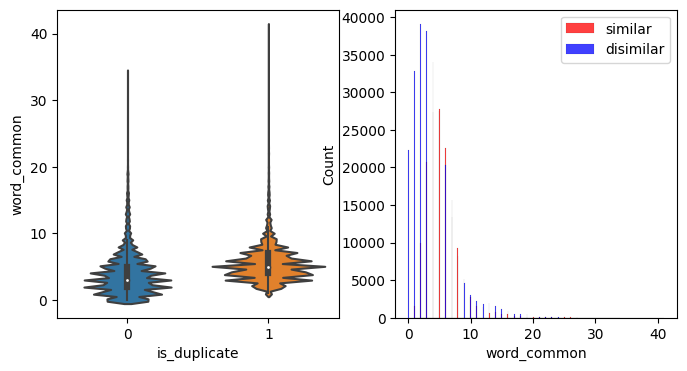

In [15]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_common',data=data)
plt.subplot(1,2,2)
sns.histplot(data[data['is_duplicate'] == 1]['word_common'],color='red',label='similar')
sns.histplot(data[data['is_duplicate'] == 0]['word_common'],color='blue',label='disimilar')
plt.legend()
plt.show()

We can see that common_words doesnot have enough information sepearting classes.The hist plots of word_common of duplicate and non-duplicate questions are overlapping. Not much information can be retrived as most of pdf's is overlapping. 

## Text Preprocessing(Cleaning)
As a part of text preprocessing, I have done

* Removing html tags
* Removing Punctuations
* Performing stemming
* Removing Stopwords
* Expanding contractions etc.


### Plotting Word Clouds

Plotting Word Clouds help us to undertand important words/features.

In [16]:
from wordcloud import WordCloud, STOPWORDS

In [17]:
data_duplicate = data[data['is_duplicate'] == 1]
data_nonduplicate = data[data['is_duplicate'] == 0]

In [18]:
sent_dup =np.dstack([data_duplicate['question1'].values,data_duplicate['question2'].values])
#words_dup = [word for sublist in sent_dup for word in sublist]
words_dup = sent_dup.flatten()
######
sent_ndup =np.dstack((data_nonduplicate['question1'].values,data_nonduplicate['question2'].values))
#words_ndup = [word for sublist in sent_ndup for word in sublist]
words_ndup = sent_ndup.flatten()

In [19]:
textp_w = words_dup
#open(path.join(d, 'train_p.txt')).read()
textn_w = words_ndup
#open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))


textn_w = [str(i) for i in textn_w]
textp_w = [str(i) for i in textp_w]
textp_w = ''.join(textp_w)
textn_w = ''.join(textn_w)

Total number of words in duplicate pair questions : 298526
Total number of words in non duplicate pair questions : 510048


### Word cloud for duplicate pair of questions

Word Cloud for Duplicate Question pairs


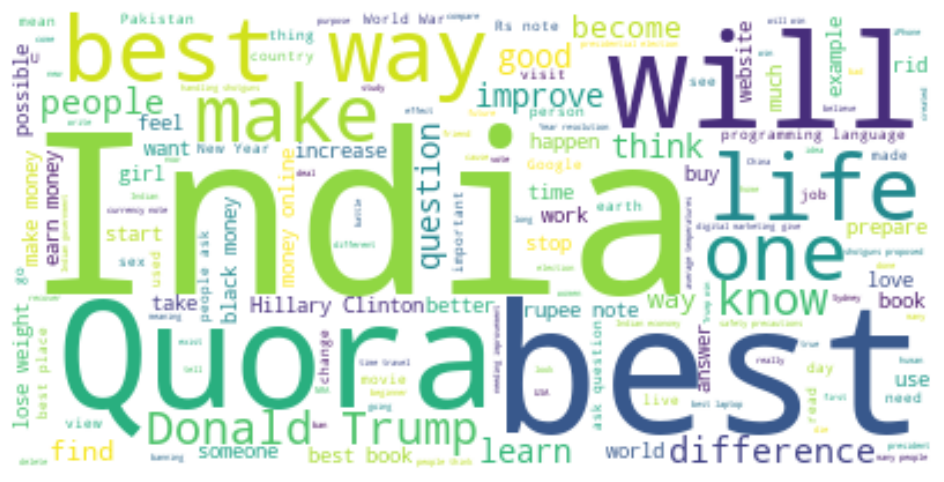

In [26]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Word cloud for non duplicate pair of questions

Word Cloud for Non Duplicate Question pairs


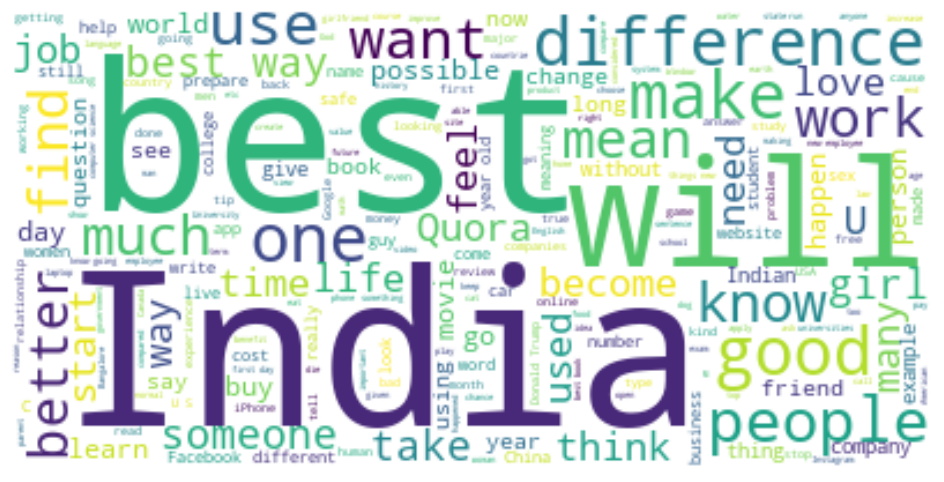

In [25]:
wc = WordCloud(background_color="white", max_words=len(textn_w), stopwords=stopwords)
wc.generate(textn_w)
print ("Word Cloud for Non Duplicate Question pairs")
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Scattertext Analysis

To visualize what words and phrases are more characteristic of a category than others.

In [23]:
import scattertext as st

In [24]:
df = st.SampleCorpora.ConventionData2012.get_data().assign(
    parse=lambda df: df.text.apply(st.whitespace_nlp_with_sentences))
corpus = st.CorpusWithoutCategoriesFromParsedDocuments(
    df, parsed_col='parse'
).build().get_unigram_corpus().remove_infrequent_words(minimum_term_count=6)

corpus.get_categories()
# Returns ['_']

TypeError: 'module' object is not callable

In [ ]:
dispersion = st.Dispersion(corpus)

dispersion_df = dispersion.get_df()
dispersion_df.head(3)

In [ ]:
dispersion_df = dispersion_df.assign(
    X=lambda df: df.Frequency,
    Xpos=lambda df: st.Scalers.log_scale(df.X),
    Y=lambda df: df["Rosengren's S"],
    Ypos=lambda df: st.Scalers.scale(df.Y),
)

In [ ]:
html = st.dataframe_scattertext(
    corpus,
    plot_df=dispersion_df,
    metadata=corpus.get_df()['speaker'] + ' (' + corpus.get_df()['party'].str.upper() + ')',
    ignore_categories=True,
    x_label='Log Frequency',
    y_label="Rosengren's S",
    y_axis_labels=['Less Dispersion', 'Medium', 'More Dispersion'],
)

### TF-IDF

TF-IDF algorithm shows the importance of a certain word in the text.